The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w}{\partial t^2} + E I \frac{\partial^4w}{\partial x^4} + \rho A c \frac{\partial w}{\partial t} = f(t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)q_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)q_j(t) $$
where $\varphi_j$ and $q_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \mathbf{q}(t) \\ \dot{\mathbf{q}}(t) \end{bmatrix}, \qquad
\mathbf{q}(t) = \left[ q_1(t), q_2(t), ..., q_n(t) \right]^T, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{q}(t) \\ \ddot{\mathbf{q}}(t) \end{bmatrix} $$

In [1]:
from beam_solutions import cont_beam
from math import pi

import numpy as np
import torch

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

from scipy.stats import qmc

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (2*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

def plot_vib_surface(ax, x, time, w, sub_samp=10):
    if len(x.shape) == 1 and len(time.shape) == 1:
        xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and time.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(time[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and time.shape[1] <= 1:
            xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = torch.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def roll_mat(data, n1, n2):
    data_ = torch.zeros((n1, n2))
    d_count = 0
    for i in range(n1):
        for j in range(n2):
            data_[i, j] = data[d_count]
            d_count += 1
    return data_

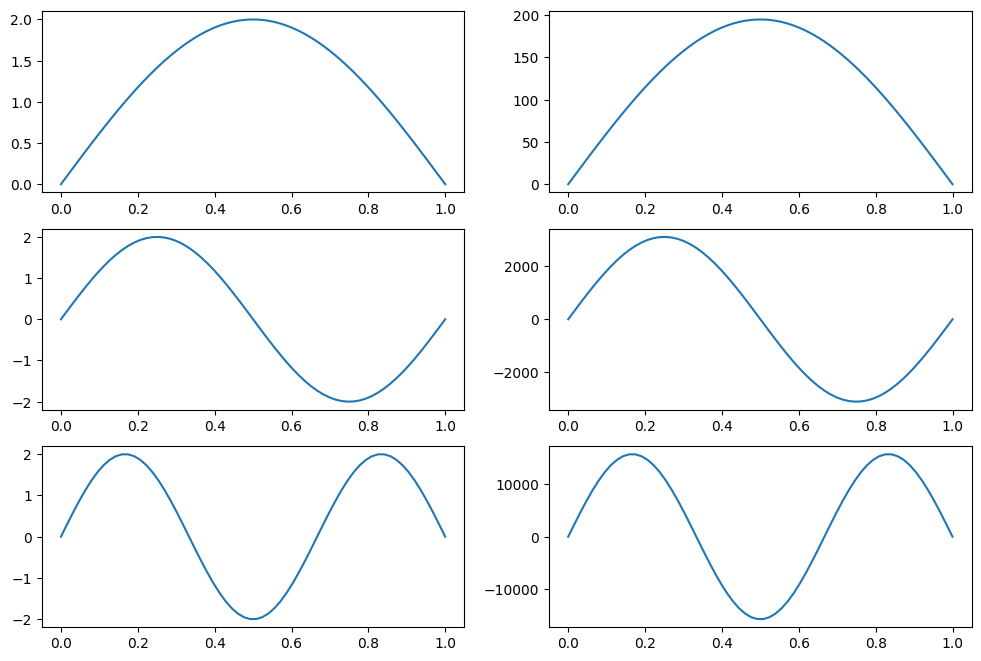

In [4]:
E = 1e7
rho = 2700
EI_ = 5e-3
pA = 1.0
c = 0.1
l = 1.0
w1 = (pi**2) * ((EI_)/(pA*(l**4)))**0.5
f1 = w1/(2*pi)
I, A, b, h = gen_beam_params(E, rho, EI_, pA)

nx = 64
nt = 128
n_modes = 6

beam_kwargs_sep = {
    "E" : E,
    "I" : I,
    "rho" : rho,
    "A" : A,
    "c" : c,
    "l" : l
}

beam_kwargs_cmb = {
    "EI" : EI_,
    "pA" : pA,
    "c" : c,
    "l" : l
}

# ss_beam = cont_beam("sep_vars", beam_kwargs_sep)
ss_beam = cont_beam("cmb_vars", **beam_kwargs_cmb)
ss_beam.gen_modes("ss-ss", n_modes, nx)

xx = ss_beam.xx
phis = ss_beam.phi_n
phis_dx4 = ss_beam.phi_dx4_n

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i in range(3):
    axs[i,0].plot(xx, phis[:,i])
    axs[i,1].plot(xx, phis_dx4[:,i])

In [ ]:
f0 = 1
init_disp = 0.1
v0 = 0.0
vv0 = torch.zeros(nx)

t = torch.linspace(0,10,nt)

# init_load = {
#     "type" : "point_load",
#     "f0" : f0,
#     "load_coord" : 0.1,
# }
# w0 = ss_beam.init_cond_load(init_load)
# wxt, wxt_n = ss_beam.free_vibration(t, w0, vv0, 0.0)

# forcing = {
#     "type" : "step_load",
#     "force_mag" : f0,
#     "load_coord" : 0.1
# }
# forcing = {
#     "type" : "harmonic",
#     "force_mag" : f0,
#     "load_coord" : 0.1,
#     "frequency" : 0.8
# }
# wxt, wxt_n = ss_beam.forced_vibration(t, forcing)

# init_disp_loc = 0.1
# init_disp_id = torch.argmin(torch.abs(ss_beam.xx - init_disp_loc))
# w0 = torch.zeros(nx)
# w0[init_disp_id] = init_disp
w0_func = lambda x : init_disp * (torch.sin(pi*x)+torch.sin(2*pi*x)+torch.sin(3*pi*x))
w0 = w0_func(ss_beam.xx)
wxt, wxtd, wxtdd, wxt_n = ss_beam.free_vibration(t, w0, vv0)
# wxt_m, wxtd_m = ss_beam.free_vibration_mdof(t, w0, vv0)

xx_g, tt = torch.meshgrid((ss_beam.xx, t), indexing="ij")